In [472]:
import json
import numpy as np
import matplotlib.pyplot as plt
import math, random, copy
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import ipywidgets as widgets

%matplotlib inline

In [486]:
# count the accuracy of our baseline
with open('prediction-child-parents.20170330.txt','r') as preds:
    tp = 0
    tn = 0
    count = 0
    for row in preds:
        myPred = json.loads(row)
        tnode = myPred['target_node']
        for idx in myPred['alpha'].keys():
            alpha = myPred['alpha'][idx]
            if int(idx) != int(tnode):
                if alpha <= 1e-6:
                    tn+=1
                else:
                    tp+=1
                count+=1
                

In [487]:
error_rate = tn / count
accuracy = tp / count
print('Error Rate (False Negative): {}'.format(error_rate))
print('Accuracy (True Positive): {}'.format(accuracy))

Error Rate (False Negative): 0.3458978608794738
Accuracy (True Positive): 0.6541021391205263


In [475]:
# count the accuracy for improved model
import time
with open('prediction-child-parents-p.txt','r') as preds:
    newtp = 0
    newtn = 0
    newcount = 0
    for row in preds:
        myPred = json.loads(row)
        tnode = myPred['target_node']
        for idx in myPred['alpha'].keys():            
            alpha = myPred['alpha'][idx]
            p_value = [ x for x in alpha if x > 1e-6]
            #print(p_value)
            #time.sleep(3)
            if int(idx) != int(tnode):
                if len(alpha)==0 or len(p_value) == 0:
                    newtn+=1
                else:
                    newtp+=1
                newcount+=1

In [490]:
error_rate = newtn / newcount
accuracy = newtp / newcount
print('Error Rate (False Negative): {}'.format(error_rate))
print('Accuracy (True Positive): {}'.format(accuracy))

Error Rate (False Negative): 0.19911323991067673
Accuracy (True Positive): 0.8008867600893232


In [477]:
# TODO
# Provide interactive analysis for choosen observation nodes

In [478]:
# Load all data, nodes, edges, and cascades
# Nodes
nodes = []
nodeHash = {}
with open('nodes.txt','r') as nodesFile:
    for node in nodesFile:
        rownode = node.replace('\n','').split(',')
        nodes.append(rownode[1])
        #nodeHash[rownode[0]] = int(rownode[1])
        nodeHash[int(rownode[1])] = rownode[0]

In [479]:
# Edges
edges = {}
followes = {}
with open('edges.txt','r') as edgesFile:
    for edge in edgesFile:
        edgeJson = edge.replace('\n','').split(',')
        if int(edgeJson[0]) not in edges.keys():
            edges[int(edgeJson[0])] = []
        if int(edgeJson[1]) not in followes.keys():
            followes[int(edgeJson[1])] = []
        edges[int(edgeJson[0])].append(int(edgeJson[1]))
        followes[int(edgeJson[1])].append(int(edgeJson[0]))

In [480]:
def pCoordinate(s2,scale=1):
    # Principal Coordinate analysis,
    # Embedd distance in the 2,3 dimension coordinates
    # Form A matrix
    # test my distance using square and triangle, looks right
    #s2 = [[0,10,14.14,10],[10,0,10,14.14],[14.14,10,0,10],[10,14.14,10,0]]
    #s2 = [[0,10,14.15],[10,0,10],[14.15,10,0]]
    Am = np.identity(s2.shape[0]) - (1/s2.shape[0])*(np.ones(s2.shape[0])*np.ones(s2.shape[0]).T)
    #logger.debug(Am)
    #logger.debug(0.5 * Am * d2 * Am.T)
    # Form W
    Wm = -0.5 * Am * s2 * Am.T
    #logger.debug(Wm)
    # calculate eigen vectors and eigen values of Wm
    evals, evecs = np.linalg.eig(Wm)
    #logger.debug('evals: {}\ndim: {}'.format(evals,evals.shape))
    #logger.debug('evecs: {}\ndim: {}'.format(evecs,evecs.shape))
    # sort by eigenvalue
    indices = np.argsort(evals)
    # turn back the order
    indices = indices[::-1]
    evecs = evecs[:,indices]
    evals = evals[indices]
    Vt = np.sqrt(np.diag(evals[:2])).dot(evecs[:,:2].T)*scale
    result = {}
    #print(Vt)
    for i in range(len(Vt[0,])):
        result[i] = [Vt[0,i],Vt[1,i]]
    return result

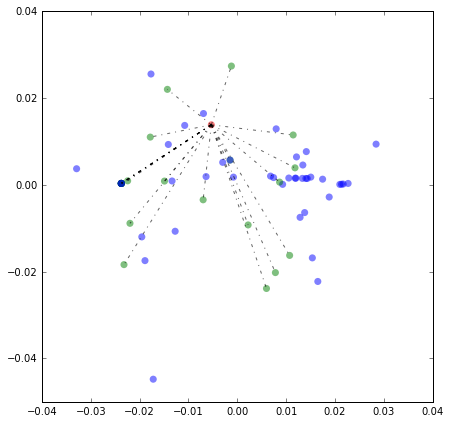

In [134]:
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mpld3 import plugins
import mpld3
from networkx.drawing.nx_agraph import graphviz_layout

shownode = tnodep5
show_mat = shownode['mat'][:,:,4]
alpha_mat = show_mat
alpha_mat = np.where(alpha_mat<0, 0, alpha_mat)
# normalize distance matrix
dist_mat = show_mat
dist_mat = np.where((dist_mat<1e-9) & (dist_mat>0), 1e-9, dist_mat)
dist_mat = np.where((dist_mat<=0), 1e-13, dist_mat)
# make diagonal distance matrix
for i in range(dist_mat.shape[0]):
    for j in range(i,dist_mat.shape[1]):
        dist_mat[i,j] = (dist_mat[i,j] + dist_mat[j,i]) / 2
        #dist_mat[i,j] = dist_mat[i,j] if dist_mat[i,j] > dist_mat[j,i] else dist_mat[j,i]
        dist_mat[j,i] = dist_mat[i,j]
#print(dist_mat)        
max_val = np.max(dist_mat)
#print(max_val) 
dist_mat = np.log(max_val/dist_mat)
#dist_mat = np.where(dist_mat<1e-13, 1e-13, dist_mat)
for i in range(dist_mat.shape[0]):
    dist_mat[i,i] = 0
#dist_mat = max_val/np.where(dist_mat<1e-13, 1e-13, dist_mat)
#dist_mat = np.where(dist_mat<1e-6, 1e-6, dist_mat)
#print(dist_mat)


#pos = pCoordinate(dist_mat)
#print(pos)

#G = nx.from_numpy_matrix(dist_mat) 
#pos=nx.spring_layout(G,dim=2,k=0.3)
#pos=graphviz_layout(G,prog='neato')
#print(pos)

# measuring distance matrix using principal coordinate analysis
noise = np.random.normal(0,1e-9,dist_mat.shape[0]*dist_mat.shape[1])
noise=noise.reshape(dist_mat.shape[0],dist_mat.shape[1])
test_dist = dist_mat + noise
pos = pCoordinate(test_dist)

trans = shownode['trans']
target_node = trans.index(shownode['target'])
colors = np.tile('',len(trans))
parents = []
neighbors = []
target = 0
for i in range(len(trans)):
    tran = trans[i]
    if tran == shownode['target']:
        colors[i]='red'
        target = i
    if tran in shownode['parents']:
        colors[i]='green'
        parents.append(i)
    if tran in shownode['neighbors']:
        colors[i]='blue'
        neighbors.append(i)
        
        
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
#ax = fig.add_subplot(111, projection='3d')

# draw the lines from parents to target
for parent in parents:
    linelabel = ax.plot([pos[target][0],pos[parent][0]],[pos[target][1],pos[parent][1]],'-.',c='black',alpha=0.6)
    #print(dist_mat[parent,target])
    #plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],dist_mat[parent,target],voffset=10, hoffset=10))

# draw the lines from the neighbors to all parent
for neighbor in neighbors:
    act_neighbor = trans[neighbor]
    # get all the parent
    myParents = edges[act_neighbor]
    for myParent in myParents:
        if myParent in trans:
            pIndex = trans.index(myParent)
            #linelabel = ax.plot([pos[neighbor][0],pos[pIndex][0]],[pos[neighbor][1],pos[pIndex][1]],'-.',c='black',alpha=0.3)
            #print(dist_mat[pIndex,neighbor])
            #plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],dist_mat[pIndex,neighbor],voffset=10, hoffset=10))

labels = []
x = []
y = []
c = []
for k, p in pos.items():
    #x.append(p[0])
    #y.append(p[1])
    #c.append(colors[k])
    #labels.append(nodeHash[trans[k]])
    scatter = ax.scatter(p[0], p[1], marker='o', c=colors[k], s=50,alpha=0.5, edgecolor='None')
    tooltip = plugins.PointHTMLTooltip(scatter, ['{}, alpha to {}: {}'.format(nodeHash[trans[k]],nodeHash[trans[target_node]],alpha_mat[k,target_node])],
                                       voffset=10,hoffset=10)
    plugins.connect(fig, tooltip)

        
    #ax.scatter(p[0], p[1], p[2], c=colors[k], marker='o')

#scatter = ax.scatter(x,y, marker='o', c=c, s=50,alpha=0.5, edgecolor='None')

    
#lgd = plt.legend(markers, labels, numpoints=1, bbox_to_anchor=(1.17, 0.5))
#plt.tight_layout()
#plt.axis('equal')
#pt.show()
#print(labels)
#tooltip = plugins.PointHTMLTooltip(scatter, labels,
#                                   voffset=10, hoffset=10)
#plugins.connect(fig, tooltip)

#mpld3.display()
mpld3.enable_notebook()


In [7]:
# plot accuarcy statistic
baseAcc = pd.read_csv('prediction-child-parents-stat.txt')
improveAcc = pd.read_csv('prediction-child-parents-p-stat.txt')

In [8]:
baseAcc['casMean'] = baseAcc.apply(lambda x: x['TotalCascade']/x['TotalNode'],axis=1)
improveAcc['casMean'] = improveAcc.apply(lambda x: x['TotalCascade']/x['TotalNode'],axis=1)

8.906629127207577

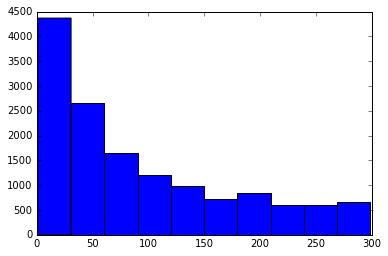

In [50]:
plt.hist(baseAcc[baseAcc.TotalCascade<300].TotalCascade)
baseAcc.groupby('TotalCascade')['TotalCascade'].count()
baseAcc.TotalCascade.mean()
baseAcc.TotalNode.mean()

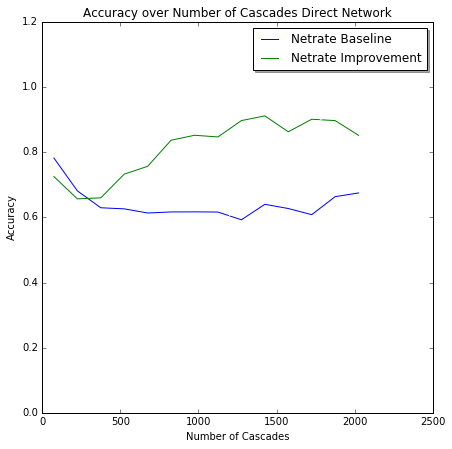

In [489]:
# bin by totalCascade
steplen = 150
maxcas=2000
casSteps = np.arange(0,maxcas,steplen)
casSteps = np.append(casSteps,maxcas)
#print(casSteps)

baseMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = baseAcc[(baseAcc['TotalCascade']>=casSteps[i])&(baseAcc['TotalCascade']<casSteps[i+1])]
    baseCasMean = sampleAcc['Accuracy'].mean()    
    if sampleAcc.shape[0]>0: 
        baseMeans.append(baseCasMean)
    else:
        baseMeans.append(baseMeans[len(baseMeans)-1])
    
improveMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = improveAcc[(improveAcc['TotalCascade']>=casSteps[i])&(improveAcc['TotalCascade']<casSteps[i+1])]
    improveCasMean = sampleAcc['Accuracy'].mean()
    if sampleAcc.shape[0]>0:
        improveMeans.append(improveCasMean)
    else:
        improveMeans.append(improveMeans[len(improveMeans)-1])
        
fig = plt.figure(figsize=(7, 7))
ahaList = (casSteps+(steplen/2)).tolist()

patch_array = []
x1 = plt.plot(ahaList[:len(ahaList)-1], baseMeans, '-',label='Netrate Baseline')
x2 = plt.plot(ahaList[:len(ahaList)-1], improveMeans, '-',label='Netrate Improvement')

plt.plot([0,maxcas],[0,1.01],color='white',marker='.')
plt.xlabel('Number of Cascades')
plt.ylabel('Accuracy')
plt.title('Accuracy over Number of Cascades Direct Network')
legend = plt.legend(loc='upper right', shadow=True)

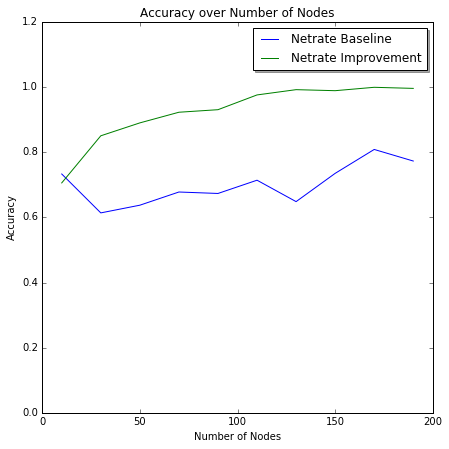

In [482]:
# bin by total Nodes
steplen = 20
maxnode=200
casSteps = np.arange(0,maxnode,steplen)
casSteps = np.append(casSteps,maxnode)
#print(casSteps)

baseMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = baseAcc[(baseAcc['TotalNode']>=casSteps[i])&(baseAcc['TotalNode']<casSteps[i+1])]
    baseCasMean = sampleAcc['Accuracy'].mean()
    if sampleAcc.shape[0]>0: 
        baseMeans.append(baseCasMean)
    else:
        baseMeans.append(baseMeans[len(baseMeans)-1])
    
improveMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = improveAcc[(improveAcc['TotalNode']>=casSteps[i])&(improveAcc['TotalNode']<casSteps[i+1])]
    improveCasMean = sampleAcc['Accuracy'].mean()
    if sampleAcc.shape[0]>0:
        improveMeans.append(improveCasMean)
    else:
        improveMeans.append(improveMeans[len(improveMeans)-1])

fig = plt.figure(figsize=(7, 7))
ahaList = (casSteps+(steplen/2)).tolist()

plt.plot(ahaList[:len(ahaList)-1], baseMeans, '-',label='Netrate Baseline')
plt.plot(ahaList[:len(ahaList)-1], improveMeans, '-',label='Netrate Improvement')
plt.plot([0,maxnode],[0,1.05],'.',color='white')

plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy over Number of Nodes')
#legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5),shadow=True)
legend = plt.legend(loc='upper right',shadow=True)

In [469]:
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mpld3 import plugins
import mpld3
from networkx.drawing.nx_agraph import graphviz_layout

def plotOneD(shownode,topic=0,scarcity=1e-5,epsilon=1e-9,scale=1):
    if len(shownode['mat'].shape) > 1:
        show_mat = shownode['mat'][:,topic]
    else:
        show_mat = shownode['mat']
    alpha_mat = show_mat
    alpha_mat = np.where(alpha_mat<0, 0, alpha_mat)
    # normalize distance matrix
    dist_matd = show_mat
    dist_matd = np.where((dist_matd<epsilon) & (dist_matd>0), epsilon, dist_matd)
    dist_matd = np.where((dist_matd<=0), 1e-20, dist_matd)

    dist_mat = np.zeros((show_mat.shape[0],show_mat.shape[0]))
    # make diagonal distance matrix
    transMat = shownode['trans']
    tarMat = shownode['target']

    dist_mat[:,transMat.index(tarMat)] = dist_matd
    for i in range(dist_matd.shape[0]):
        dist_mat[transMat.index(tarMat),i] = dist_matd[i]

    # add small value
    #dist_mat = np.where((dist_mat<=0), 1e-13, dist_mat)

    # add non significant noise to distance matrix for variational rotation
    dist_mat = np.where((dist_mat<=0), np.abs(np.random.normal(0,scarcity)), dist_mat)

    #print(dist_mat)

    for i in range(dist_mat.shape[0]):
        for j in range(i,dist_mat.shape[1]):
            dist_mat[i,j] = (dist_mat[i,j] + dist_mat[j,i]) / 2
            #dist_mat[i,j] = dist_mat[i,j] if dist_mat[i,j] > dist_mat[j,i] else dist_mat[j,i]
            dist_mat[j,i] = dist_mat[i,j]
    #print(dist_mat)        
    max_val = np.max(dist_mat)
    #print(max_val) 
    dist_mat = np.log(max_val/dist_mat)
    #dist_mat = np.where(dist_mat<1e-13, 1e-13, dist_mat)
    for i in range(dist_mat.shape[0]):
        dist_mat[i,i] = 0
    #dist_mat = max_val/np.where(dist_mat<1e-13, 1e-13, dist_mat)
    #dist_mat = np.where(dist_mat<1e-6, 1e-6, dist_mat)
    #print(dist_mat)

    #print(dist_mat)

    #pos = pCoordinate(dist_mat)
    #print(pos)

    #G = nx.from_numpy_matrix(dist_mat) 
    #pos=nx.spring_layout(G,dim=2)
    #pos=graphviz_layout(G,prog='neato')
    #print(pos)

    # measuring distance matrix using principal coordinate analysis
    """
    noise = np.random.normal(0,1e-9,dist_mat.shape[0]*dist_mat.shape[1])
    noise=noise.reshape(dist_mat.shape[0],dist_mat.shape[1])
    test_dist = dist_mat + noise
    pos = pCoordinate(test_dist)
    """
    pos = pCoordinate(dist_mat,scale)

    trans = shownode['trans']
    target_node = trans.index(shownode['target'])
    colors = np.tile('',len(trans))
    parents = []
    neighbors = []
    target = 0
    for i in range(len(trans)):
        tran = trans[i]
        if tran == shownode['target']:
            colors[i]='red'
            target = i
        if tran in shownode['parents']:
            colors[i]='green'
            parents.append(i)
        if tran in shownode['neighbors']:
            colors[i]='blue'
            neighbors.append(i)


    #print(parents)
            
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    #ax = fig.add_subplot(111, projection='3d')

    # draw the lines from parents to target
    for parent in parents:
        linelabel = ax.plot([pos[target][0],pos[parent][0]],[pos[target][1],pos[parent][1]],'-.',c='black',alpha=0.6)
        #print(dist_mat[parent,target])
        #plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],dist_mat[parent,target],voffset=10, hoffset=10))

    # draw the lines from the neighbors to all parent
    for neighbor in neighbors:
        act_neighbor = trans[neighbor]
        # get all the parent
        myParents = edges[act_neighbor]
        for myParent in myParents:
            if myParent in trans:
                pIndex = trans.index(myParent)
                #linelabel = ax.plot([pos[neighbor][0],pos[pIndex][0]],[pos[neighbor][1],pos[pIndex][1]],'-.',c='black',alpha=0.3)
                #print(dist_mat[pIndex,neighbor])
                #plugins.connect(fig, plugins.LineLabelTooltip(linelabel[0],dist_mat[pIndex,neighbor],voffset=10, hoffset=10))

    labels = []
    x = []
    y = []
    c = []
    for k, p in pos.items():
        #x.append(p[0])
        #y.append(p[1])
        #c.append(colors[k])
        #labels.append(nodeHash[trans[k]])
        scatter = ax.scatter(p[0], p[1], marker='o', c=colors[k], s=50,alpha=0.5, edgecolor='None')
        tooltip = plugins.PointHTMLTooltip(scatter, ['{}, alpha to {}: {}'.format(nodeHash[trans[k]],nodeHash[trans[target_node]],alpha_mat[k])],
                                           voffset=10,hoffset=10)
        plugins.connect(fig, tooltip)
    plt.title('Distance Visualization Target Node: {}'.format(nodeHash[trans[target_node]]))
    

        #ax.scatter(p[0], p[1], p[2], c=colors[k], marker='o')

    #scatter = ax.scatter(x,y, marker='o', c=c, s=50,alpha=0.5, edgecolor='None')


    #lgd = plt.legend(markers, labels, numpoints=1, bbox_to_anchor=(1.17, 0.5))
    #plt.tight_layout()
    #plt.axis('equal')
    #pt.show()
    #print(labels)
    #tooltip = plugins.PointHTMLTooltip(scatter, labels,
    #                                   voffset=10, hoffset=10)
    #plugins.connect(fig, tooltip)

    #mpld3.display()
    mpld3.enable_notebook()


In [223]:
# read the result with probability
predChildParArr = {}
with open('prediction-child-parents.20170331.txt','r') as predFile:
    for pred in predFile:
        predJson = json.loads(pred)
        predObj = {}
        target_node = predJson['target_node'] 
        transArr = [target_node]
        alphaArr = []
        parentArr = []
        # recreate alpha matrix
        for key,alpha in predJson['alpha'].items():
            if int(key) not in transArr:
                transArr.append(int(key))
            alphaArr.append(np.array(alpha))
            if int(key) != int(target_node):
                parentArr.append(int(key))
        predChildParArr[target_node] = {'target':target_node,'trans':transArr,'parents':parentArr,'neighbors':[],'mat':np.array(alphaArr)}

In [224]:
# list all the key and website for visualization
idlistnop = list(predChildParArr.keys())
weblistnop = [nodeHash[x] for x in idlistnop]

In [225]:
def shownopplot(web):
    nodeid = weblistnop.index(web[0])
    plotOneD(predChildParArr[idlistnop[nodeid]])

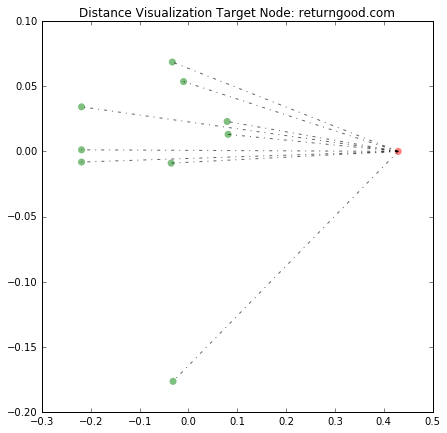

In [483]:
# make ipython widgets
"""
dropdownQuantity = widgets.SelectMultiple(
            options = weblistnop,
            value=[weblistnop[0]],
            description='Target Website'
        )
"""        
webchoose = random.sample(weblistnop,2000)

dropdownQuantity = widgets.SelectMultiple(
            options = webchoose,
            value=[webchoose[0]],
            description='Target Website'
        )

widgets.interact(shownopplot,web=dropdownQuantity)

In [310]:
# read the result with probability
predChildParProbArr = {}
with open('prediction-child-parents-p.20170417.txt','r') as predFile:
    for pred in predFile:
        predJson = json.loads(pred)
        predObj = {}
        target_node = predJson['target_node'] 
        transArr = [target_node]
        alphaArr = []
        parentArr = []
        # recreate alpha matrix
        for key,alpha in predJson['alpha'].items():
            if int(key) not in transArr:
                transArr.append(int(key))
            alphaArr.append(np.array(alpha))
            if int(key) != int(target_node):
                parentArr.append(int(key))
        if len(parentArr)>2 :
            predChildParProbArr[target_node] = {'target':target_node,'trans':transArr,'parents':parentArr,'neighbors':[],'mat':np.array(alphaArr)}

In [491]:
# list all the key and website for visualization
idlistwip = list(predChildParProbArr.keys())
weblistwip = [nodeHash[x] for x in idlistwip]

listTopic = ['War','Motivation','Peace','Politic','Opression','Housing','Journal','History','Game','Army','Teamwork','Election','Finance','Danger','Innovation']

def showwipplot(web,topic):
    topic = listTopic.index(topic)
    nodeid = weblistwip.index(web[0])
    #print(predChildParProbArr[idlistwip[nodeid]])
    plotOneD(predChildParProbArr[idlistwip[nodeid]],topic-1)

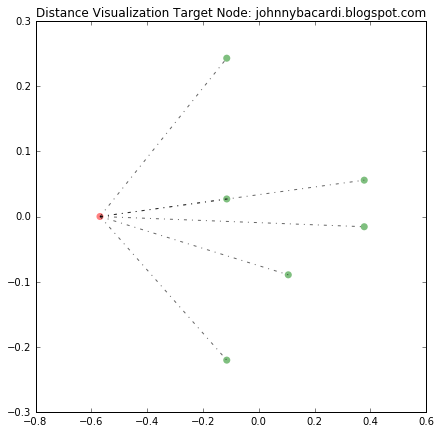

In [492]:
# make ipython widgets
"""
dropdownWebsite = widgets.SelectMultiple(
            options = weblistnop,
            value=[weblistnop[0]],
            description='Target Website'
        )
"""
webchoose = random.sample(weblistwip,3000)
dropdownWebsite = widgets.SelectMultiple(
            options = webchoose,
            value=[webchoose[0]],
            description='Target Website'
        )

dropDownTopic = widgets.Dropdown(
            options = listTopic,
            value= listTopic[0],
            description='Topic'
        )

widgets.interact(showwipplot,web=dropdownWebsite,topic=dropDownTopic)

In [454]:
# Visualization for neighbor
# read the result with probability
predNeighParProbArr = {}
with open('prediction-neighbors-probs.txt','r') as predFile:
    for pred in predFile:
        predJson = json.loads(pred)
        target_node = predJson['target_node'] 
        transArr = predJson['trans']
        alphaArr = predJson['alpha']
        parentArr = predJson['parents']
        neighborArr= predJson['neighbors']
        predNeighParProbArr[target_node] = {'target':target_node,'trans':transArr,'parents':parentArr,'neighbors':neighborArr,'mat':np.array(alphaArr)}

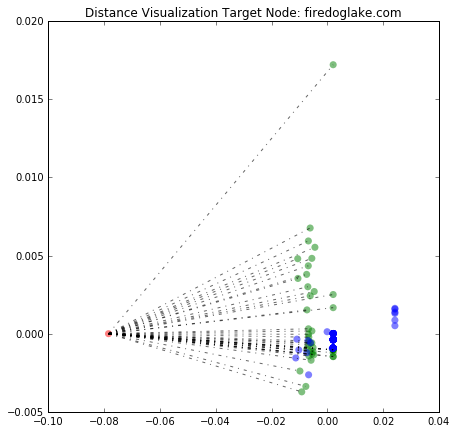

In [497]:
# make ipython widgets
"""
dropdownWebsite = widgets.SelectMultiple(
            options = weblistnop,
            value=[weblistnop[0]],
            description='Target Website'
        )
"""
# list all the key and website for visualization
idlistneighwip = list(predNeighParProbArr.keys())
weblistneighwip = [nodeHash[x] for x in idlistneighwip]

listTopic = ['War','Motivation','Peace','Politic','Opression','Housing','Journal','History','Game','Army','Teamwork','Election','Finance','Danger','Innovation']


def showneighwipplot(web,topic):
    topic = listTopic.index(topic)
    nodeid = weblistwip.index(web[0])
    plotOneD(predNeighParProbArr[idlistwip[nodeid]],topic-1,scarcity=1e-3,epsilon=1e-6,scale=2)

dropdownWebsite = widgets.SelectMultiple(
            options = weblistneighwip,
            value=[weblistneighwip[0]],
            description='Target Website'
        )

dropDownTopic = widgets.Dropdown(
            options = listTopic,
            value= listTopic[0],
            description='Topic'
        )

widgets.interact(showneighwipplot,web=dropdownWebsite,topic=dropDownTopic)

In [451]:
neighBase = pd.read_csv('prediction-neighbors-exp-stat.txt')
neighImprove = pd.read_csv('prediction-neighbors-probs-exp-stat.txt')

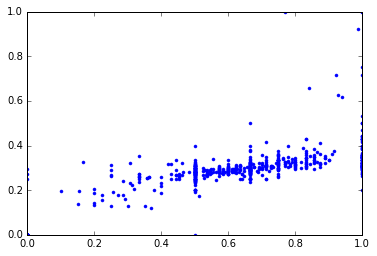

In [452]:
tp = neighBase.TP/(neighBase.TP+neighBase.TN)
fp = neighBase.FP/(neighBase.FP+neighBase.FN)
plt.plot(fp.values.tolist(),tp.values.tolist(),'.')
tp = neighImprove.TP/(neighImprove.TP+neighImprove.TN)
fp = neighImprove.FP/(neighImprove.FP+neighImprove.FN)
#plt.plot(fp.values.tolist(),tp.values.tolist(),'.')

0.8336996394973271
0.9146514734843835


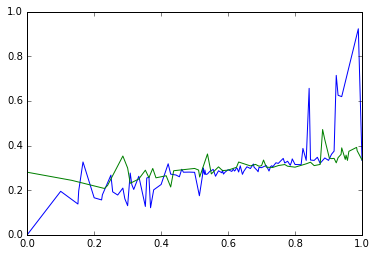

In [495]:
tp = neighBase.TP/(neighBase.TP+neighBase.TN)
fp = neighBase.FP/(neighBase.FP+neighBase.FN)
fptp = pd.DataFrame({'fp':fp,'tp':tp})
baseROC = fptp.groupby('fp')['tp'].median()
plt.plot(baseROC.index.tolist(),baseROC.values.tolist(),'-')
tp = neighImprove.TP/(neighImprove.TP+neighImprove.TN)
fp = neighImprove.FP/(neighImprove.FP+neighImprove.FN)
fptp = pd.DataFrame({'fp':fp,'tp':tp})
fptp.append({'fp':0,'tp':0},ignore_index=True)
baseROC = fptp.groupby('fp')['tp'].median()
plt.plot(baseROC.index.tolist(),baseROC.values.tolist(),'-')
print(((neighBase['TP']+neighBase['TN'])/(neighBase['TP']+neighBase['TN']+neighBase.FP+neighBase.FN)).mean())
print(((neighImprove['TP']+neighImprove['TN'])/(neighImprove['TP']+neighImprove['TN']+neighImprove.FP+neighImprove.FN)).mean())

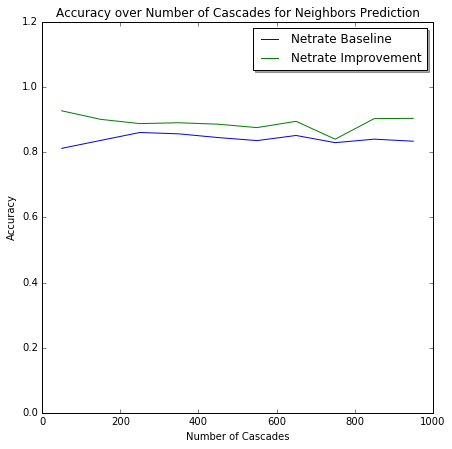

In [447]:
# bin by totalCascade
steplen = 100
maxcas=1000
casSteps = np.arange(0,maxcas,steplen)
casSteps = np.append(casSteps,maxcas)
#print(casSteps)

baseMeans = []
improveMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = neighBase[(neighBase['TotalCascade']>=casSteps[i])&(neighBase['TotalCascade']<casSteps[i+1])]
    #baseCasMean = sampleAcc['Precision'].mean()
    baseCasMean = ((sampleAcc['TP']+sampleAcc['TN'])/(sampleAcc['TotalNode']-1)).mean()        
    if sampleAcc.shape[0]>0: 
        baseMeans.append(baseCasMean)
    else:
        baseMeans.append(baseMeans[len(baseMeans)-1])

        
for i in range(len(casSteps)-1):
    sampleAcc = neighImprove[(neighImprove['TotalCascade']>=casSteps[i])&(neighImprove['TotalCascade']<casSteps[i+1])]
    #baseCasMean = sampleAcc['Precision'].mean()    
    baseCasMean = ((sampleAcc['TP']+sampleAcc['TN'])/(sampleAcc['TotalNode']-1)).mean()        
    if sampleAcc.shape[0]>0: 
        improveMeans.append(baseCasMean)
    else:
        improveMeans.append(baseMeans[len(baseMeans)-1])
        
        
fig = plt.figure(figsize=(7, 7))
ahaList = (casSteps+(steplen/2)).tolist()

plt.plot(ahaList[:len(ahaList)-1], baseMeans, '-',label='Netrate Baseline')
plt.plot([0,maxnode],[0,1.05],'.',color='white')

plt.plot(ahaList[:len(ahaList)-1], improveMeans, '-',label='Netrate Improvement')
plt.plot([0,maxnode],[0,1.05],'.',color='white')



plt.xlabel('Number of Cascades')
plt.ylabel('Accuracy')
plt.title('Accuracy over Number of Cascades for Neighbors Prediction')
#legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5),shadow=True)
legend = plt.legend(loc='upper right',shadow=True)

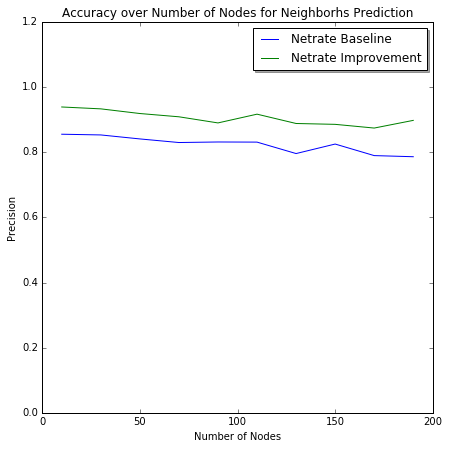

In [493]:
# bin by totalNode
steplen = 20
maxcas=200
casSteps = np.arange(0,maxcas,steplen)
casSteps = np.append(casSteps,maxcas)
#print(casSteps)

baseMeans = []
improveMeans = []

for i in range(len(casSteps)-1):
    sampleAcc = neighBase[(neighBase['TotalNode']>=casSteps[i])&(neighBase['TotalNode']<casSteps[i+1])]
    #baseCasMean = sampleAcc['Precision'].mean()    
    baseCasMean = ((sampleAcc['TP']+sampleAcc['TN'])/(sampleAcc['TP']+sampleAcc['TN']+sampleAcc.FP+sampleAcc.FN)).mean()    
    if sampleAcc.shape[0]>0: 
        baseMeans.append(baseCasMean)
    else:
        baseMeans.append(baseMeans[len(baseMeans)-1])

        
for i in range(len(casSteps)-1):
    sampleAcc = neighImprove[(neighImprove['TotalNode']>=casSteps[i])&(neighImprove['TotalNode']<casSteps[i+1])]
    #baseCasMean = sampleAcc['Precision'].mean()    
    baseCasMean = ((sampleAcc['TP']+sampleAcc['TN'])/(sampleAcc['TotalNode']-1)).mean()    
    if sampleAcc.shape[0]>0: 
        improveMeans.append(baseCasMean)
    else:
        improveMeans.append(baseMeans[len(baseMeans)-1])
        
        
fig = plt.figure(figsize=(7, 7))
ahaList = (casSteps+(steplen/2)).tolist()

plt.plot(ahaList[:len(ahaList)-1], baseMeans, '-',label='Netrate Baseline')
plt.plot([0,maxnode],[0,1.05],'.',color='white')

plt.plot(ahaList[:len(ahaList)-1], improveMeans, '-',label='Netrate Improvement')
plt.plot([0,maxnode],[0,1.05],'.',color='white')



plt.xlabel('Number of Nodes')
plt.ylabel('Precision')
plt.title('Accuracy over Number of Nodes for Neighborhs Prediction')
#legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5),shadow=True)
legend = plt.legend(loc='upper right',shadow=True)

In [337]:
tedges = {}
tfollowes = {}
cascade_checker = {}
cascade_count=0
cascades = {}
nodeCascades = {}
with open('cascade-file-parent-probs.txt','r') as casFile:
    for casRead in casFile:
        # prepare cascade
        # load cascade from the file
        obsNode = json.loads(casRead)
        #print(obsNode)
        parent_node = obsNode['node']
        if parent_node not in tfollowes:
            tfollowes[parent_node] = []
        for obsCascades in obsNode['cascades']:
            if obsCascades['url'] not in cascade_checker:
                cascade_checker[obsCascades['url']] = 1
            else:
                continue
            cascade_id = cascade_count
            cascades[cascade_id] = {'probs': obsCascades['probs'],'cas': []}
            for obsCas in obsCascades['cas']:
                dst = int(obsCas['node'])
                if dst not in tfollowes[parent_node]:
                    tfollowes[parent_node].append(dst)
                if dst not in tedges:
                    tedges[dst] = []
                if parent_node not in tedges[dst]:
                    tedges[dst].append(parent_node)
                
                at = float(obsCas['time'])/2505600
                cascades[cascade_id]['cas'].append((at, dst))                

                # append cascadeid to nodes
                if dst not in nodeCascades.keys():
                    nodeCascades[dst] = []
                nodeCascades[dst].append(cascade_id)
            # add new cascade id
            cascade_count+=1

In [338]:
neighbor_net = {}
for key, parents in tedges.items():
    neighborArr = []
    for parent in parents:
        if parent in tfollowes:
            for neighbor in tfollowes[parent]:
                if neighbor in parents:
                    if neighbor not in neighborArr:
                        neighborArr.append(neighbor)
    if len(neighborArr) > 0:
        neighbor_net[key] = neighborArr            

In [340]:
with open('neighbor_net.txt','w') as neighFile:
    neighFile.write(json.dumps(neighbor_net))

In [339]:
neighbor_net

{1: [5231, 9094, 41356],
 32770: [32770],
 32771: [1552,
  2883,
  6250,
  6677,
  7191,
  8099,
  10589,
  20095,
  13864,
  15176,
  15344,
  16497,
  16642,
  23661,
  26347,
  26559,
  28721,
  40479,
  29189,
  29083,
  30041,
  32147,
  42910],
 5: [41083, 42338],
 32769: [12778],
 8: [1655],
 9: [4219, 33011],
 32778: [11636],
 11: [11, 2883, 10894],
 32783: [29289, 33607],
 16: [41529],
 32785: [11293, 15981, 41819],
 3: [3882, 29542, 30456, 34265, 36024, 44176],
 10926: [23847, 43379],
 32790: [17099, 42295],
 32791: [4910],
 25: [41039, 45009],
 32795: [41069],
 32796: [12109],
 29: [3171, 6984],
 32798: [40043, 42710],
 32: [22094, 29794],
 33: [23217, 29852, 41642],
 32802: [35362],
 32803: [6859, 22653, 26137],
 36: [27055],
 38: [43090],
 43697: [43697],
 32808: [26071],
 6548: [2732],
 7: [23958],
 32812: [25811, 30041],
 45: [33946],
 32814: [12115],
 32815: [6344, 15176],
 32776: [7041],
 50: [12472],
 52: [21831],
 32822: [2202,
  24626,
  7113,
  37173,
  7389,
  767

In [341]:
len(neighbor_net)

20265

In [342]:
array_aha = []
for key,test in neighbor_net.items():
    if len(test) > 0:
        array_aha.append(key)

In [343]:
# get sample node list, 10 for each node
nodelist = baseAcc['TotalNode'].unique()
nodelist = np.sort(nodelist)
#sampleArr = []
for totalnode in nodelist:
    total_sample=200
    #targetnodes = baseAcc[baseAcc['TotalNode']==totalnode]['TargetNode']
    targetnodes = baseAcc[baseAcc['TotalNode']==totalnode]
    targetnodes = targetnodes[targetnodes['TargetNode'].isin(array_aha)].TargetNode
    total_sample=total_sample if targetnodes.shape[0] > total_sample else targetnodes.shape[0]
    sample = targetnodes.iloc[random.sample(range(targetnodes.shape[0]),total_sample)].values.tolist()
    if len(sample)>0:
#        print(sample[0])
#        print(neighbor_net[sample[0]])
    #print()
        with open('sample-neighbor-experiment.txt','a') as sampleFile:
            sampleFile.write('{}\n'.format(json.dumps({'totalnode':int(totalnode),'sample':sample})))
    #sampleArr.append(sample)

In [299]:
nodelist[0:100]

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  99, 100, 101, 102, 103])